In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
import math


# Feature Selection and Encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler,OrdinalEncoder
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import optuna
from catboost import CatBoostClassifier, Pool
from optuna import Trial
from optuna.samplers import TPESampler

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

In [27]:
# data_df = pd.read_csv('./pre_credit_df(fill_groupby).csv', index_col=0) # 엑셀 파일 읽기
data_df = pd.read_csv('./pre_final.csv', index_col=0) # 엑셀 파일 읽기

In [28]:
data_df = data_df.reset_index().drop(['index'],axis=1)
data_df

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,email,occyp_type,family_size,begin_month,credit,Age,dup,cards,family_category,occyp_category
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,4709,...,0,Laborers,2.0,6.0,1.0,38.079452,1,5,small,1.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,...,1,Laborers,3.0,5.0,1.0,31.178082,1,9,small,1.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,4434,...,0,Managers,2.0,22.0,2.0,52.293151,1,6,small,0.0
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,...,0,Sales staff,2.0,37.0,0.0,41.336986,1,2,small,1.0
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,2105,...,0,Managers,2.0,26.0,2.0,41.197260,0,1,small,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,0,0,0,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,1984,...,0,Core staff,4.0,2.0,1.0,33.093151,1,5,big,0.0
26447,0,0,1,1,180000.0,Working,Higher education,Separated,House / apartment,2475,...,0,Laborers,2.0,47.0,2.0,41.893151,0,1,small,1.0
26448,0,1,0,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,2015,...,0,Core staff,2.0,25.0,2.0,27.621918,0,1,small,0.0
26449,1,0,1,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,107,...,0,Laborers,1.0,59.0,2.0,27.794521,0,1,Nuclear,1.0


### Target, Feature 분리

In [33]:
credit_Y = data_df['credit']
credit_X = data_df.drop(['credit'],axis=1)

### Pipeline 활용한 encoding

In [18]:
def pipe_processing(x_train, x_test):
    #numeric, categorical feature 정리
    numeric_features = ['income_total','DAYS_EMPLOYED','family_size','begin_month','Age','cards']
    numeric_transformer = StandardScaler()

    categorical_features = ['child_num','income_type','edu_type','family_type','house_type','occyp_type','family_category','occyp_category']
    categorical_transformer = OneHotEncoder()

    pass_through = ['gender','car','reality','work_phone','phone','email','dup']

    preprocessor = ColumnTransformer(
        transformers=[ # List of (name, transformer, column(s))
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('pass_through','passthrough',pass_through)])

    preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)]) # preprocessing-only

    preprocessor_pipe.fit(x_train)
    x_train_transformed = preprocessor_pipe.transform(x_train)
    x_test_transformed = preprocessor_pipe.transform(x_test)
    
    return x_train_transformed, x_test_transformed, preprocessor

### 인코딩한 Dataframe 열 이름 생성

In [19]:
def get_feature_names(column_transformer):

    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

## ML

In [48]:
!pip install --upgrade ngboost

     -------------------------------------- 349.1/349.1 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 68.2/68.2 KB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 48.8/48.8 KB 2.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4034 sha256=aca110627331dc9b03167c921aa20168b6c406116e648d05d93b602956c05d84
  Stored in directory: c:\users\yeonjun jeong\appdata\local\pip\cache\wheels\16\a2\b6\582cfdfbeeccd469504a01af3bb952fd9e7eccba40995eafea
Successfully built autograd-gamma


In [52]:
!pip install --upgrade catboost

     ---------------------------------------- 73.9/73.9 MB 7.1 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 KB ? eta 0:00:00
     ---------------------------------------- 28.8/28.8 MB 9.6 MB/s eta 0:00:00


In [8]:
# Machine learning 
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model, neighbors, svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold, cross_val_score
from vecstack import stacking
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical, Bernoulli
from catboost import CatBoostClassifier, Pool

In [9]:
#분석 설정값

test_size = 0.2
random_state = 0
num_folds= 5 # test_size = 0.2
str_kf = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_state)

In [13]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,20))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

### Gradient Boosting Classifier

In [20]:
logloss_history = []
accuracy_history = []

for train_index, test_index in str_kf.split(credit_X, credit_Y):
    X_train, X_test = credit_X.loc[train_index], credit_X.loc[test_index]
    y_train, y_test = credit_Y.loc[train_index], credit_Y.loc[test_index]

    x_train_transformed , x_test_transformed, preprocessor = pipe_processing(X_train, X_test)
    new_col_names = get_feature_names(preprocessor)
    x_train_transformed = pd.DataFrame(x_train_transformed,columns=new_col_names)
    x_test_transformed = pd.DataFrame(x_test_transformed,columns=new_col_names)
    x_train_transformed.head()

    model = GradientBoostingClassifier(random_state=random_state)
    model.fit(x_train_transformed, y_train) # <- x_train_transformed (not x_train)
    
    y_pred_proba = model.predict_proba(x_test_transformed)
    y_pred = model.predict(x_test_transformed) # 예측 라벨
    logloss_history.append(log_loss(y_test,y_pred_proba)) # logloss측정 및 기록
    accuracy_history.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록

print("각 분할의 logloss 기록 :", logloss_history)    
print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 logloss :", np.mean(logloss_history))
print("평균 정확도 :", np.mean(accuracy_history))   

각 분할의 logloss 기록 : [0.7908334071109172, 0.7891547725570159, 0.7878121309827295, 0.7901636524139231, 0.787920006240549]
각 분할의 정확도 기록 : [0.6930636930636931, 0.692249527410208, 0.6935727788279773, 0.6926275992438563, 0.6973534971644613]
평균 logloss : 0.7891767938610269
평균 정확도 : 0.6937734191420392


### Extreme Gradient Boosting Classifier

In [22]:
logloss_history = []
accuracy_history = []

for train_index, test_index in str_kf.split(credit_X, credit_Y):
    X_train, X_test = credit_X.loc[train_index], credit_X.loc[test_index]
    y_train, y_test = credit_Y.loc[train_index], credit_Y.loc[test_index]

    x_train_transformed , x_test_transformed, preprocessor = pipe_processing(X_train, X_test)
    new_col_names = get_feature_names(preprocessor)
    x_train_transformed = pd.DataFrame(x_train_transformed,columns=new_col_names)
    x_test_transformed = pd.DataFrame(x_test_transformed,columns=new_col_names)


    model = XGBClassifier(objective='multi:softmax',num_classes=3,random_state=random_state, eval_metric='mlogloss' )
    model.fit(x_train_transformed, y_train) # <- x_train_transformed (not x_train)
    
    y_pred_proba = model.predict_proba(x_test_transformed)
    y_pred = model.predict(x_test_transformed) # 예측 라벨
    logloss_history.append(log_loss(y_test,y_pred_proba)) # logloss측정 및 기록
    accuracy_history.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록

print("각 분할의 logloss 기록 :", logloss_history)    
print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 logloss :", np.mean(logloss_history))
print("평균 정확도 :", np.mean(accuracy_history))   

[16:13:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:13:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:13:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This c

### Light GBM Classifier

In [23]:
logloss_history = []
accuracy_history = []

for train_index, test_index in str_kf.split(credit_X, credit_Y):
    X_train, X_test = credit_X.loc[train_index], credit_X.loc[test_index]
    y_train, y_test = credit_Y.loc[train_index], credit_Y.loc[test_index]

    x_train_transformed , x_test_transformed, preprocessor = pipe_processing(X_train, X_test)
    new_col_names = get_feature_names(preprocessor)
    x_train_transformed = pd.DataFrame(x_train_transformed,columns=new_col_names)
    x_test_transformed = pd.DataFrame(x_test_transformed,columns=new_col_names)
    x_train_transformed.head()

    model = LGBMClassifier(random_state=random_state)
    model.fit(x_train_transformed, y_train) # <- x_train_transformed (not x_train)
    
    y_pred_proba = model.predict_proba(x_test_transformed)
    y_pred = model.predict(x_test_transformed) # 예측 라벨
    logloss_history.append(log_loss(y_test,y_pred_proba)) # logloss측정 및 기록
    accuracy_history.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록

print("각 분할의 logloss 기록 :", logloss_history)    
print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 logloss :", np.mean(logloss_history))
print("평균 정확도 :", np.mean(accuracy_history))   

각 분할의 logloss 기록 : [0.7480738589354607, 0.7452357857616125, 0.7452162418239024, 0.7530925771056128, 0.748206216107135]
각 분할의 정확도 기록 : [0.7045927045927046, 0.709640831758034, 0.7085066162570889, 0.7085066162570889, 0.7064272211720227]
평균 logloss : 0.7479649359467447
평균 정확도 : 0.7075347980073878


### NGBOOST Classfier

In [26]:
logloss_history = []
accuracy_history = []

for train_index, test_index in str_kf.split(credit_X, credit_Y):
    X_train, X_test = credit_X.loc[train_index], credit_X.loc[test_index]
    y_train, y_test = credit_Y.loc[train_index], credit_Y.loc[test_index]
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    x_train_transformed , x_test_transformed, preprocessor = pipe_processing(X_train, X_test)
    new_col_names = get_feature_names(preprocessor)
    x_train_transformed = pd.DataFrame(x_train_transformed,columns=new_col_names)
    x_test_transformed = pd.DataFrame(x_test_transformed,columns=new_col_names)


    model = NGBClassifier(Dist=k_categorical(3), random_state=random_state)
    model.fit(x_train_transformed, y_train, X_val=x_test_transformed, Y_val=y_test) # <- x_train_transformed (not x_train)
    
    y_pred_proba = model.predict_proba(x_test_transformed)
    y_pred = model.predict(x_test_transformed) # 예측 라벨
    logloss_history.append(log_loss(y_test,y_pred_proba)) # logloss측정 및 기록
    accuracy_history.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록

print("각 분할의 logloss 기록 :", logloss_history)    
print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 logloss :", np.mean(logloss_history))
print("평균 정확도 :", np.mean(accuracy_history))   

[iter 0] loss=0.8825 val_loss=0.8799 scale=2.0000 norm=6.8284
[iter 100] loss=0.8049 val_loss=0.8101 scale=2.0000 norm=6.5759
[iter 200] loss=0.7956 val_loss=0.8029 scale=1.0000 norm=3.2909
[iter 300] loss=0.7915 val_loss=0.8003 scale=1.0000 norm=3.2917
[iter 400] loss=0.7890 val_loss=0.7992 scale=2.0000 norm=6.5876
[iter 0] loss=0.8825 val_loss=0.8798 scale=2.0000 norm=6.8284
[iter 100] loss=0.8045 val_loss=0.8126 scale=2.0000 norm=6.5815
[iter 200] loss=0.7956 val_loss=0.8059 scale=1.0000 norm=3.2949
[iter 300] loss=0.7918 val_loss=0.8034 scale=1.0000 norm=3.2971
[iter 400] loss=0.7898 val_loss=0.8022 scale=1.0000 norm=3.2986
[iter 0] loss=0.8826 val_loss=0.8793 scale=2.0000 norm=6.8284
[iter 100] loss=0.8056 val_loss=0.8071 scale=2.0000 norm=6.5799
[iter 200] loss=0.7974 val_loss=0.8013 scale=1.0000 norm=3.2972
[iter 300] loss=0.7941 val_loss=0.7999 scale=0.5000 norm=1.6501
[iter 400] loss=0.7923 val_loss=0.8000 scale=1.0000 norm=3.3009
[iter 0] loss=0.8826 val_loss=0.8796 scale=2.0

### CATBOOST Classifier

### optuna를 통한 hyper parameter 찾기

In [41]:
def objective(trial):
    param = {
      "random_state":0,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }

    X_train, X_valid, y_train, y_valid = train_test_split(credit_X,credit_Y,test_size=0.2)

    cat_features = ['income_type','edu_type','family_type','house_type','occyp_type','family_category']
    cat = CatBoostClassifier(**param)
    cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
    cat_pred = cat.predict_proba(X_valid)
    log_score = log_loss(y_valid, cat_pred)

    return log_score

In [ ]:
sampler = TPESampler(seed=0)
study = optuna.create_study(
    study_name="cat_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=5)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-05-10 13:06:36,868] A new study created in memory with name: cat_parameter_opt


0:	learn: 1.0631774	test: 1.0631774	test1: 1.0644989	best: 1.0644989 (0)	total: 209ms	remaining: 22m 22s
100:	learn: 0.4930111	test: 0.5101801	test1: 0.7467965	best: 0.7467311 (99)	total: 27.4s	remaining: 28m 32s


[I 2022-05-10 13:07:14,198] Trial 0 finished with value: 0.7467310741855596 and parameters: {'learning_rate': 0.0646642271741456, 'bagging_temperature': 7.257005721594282, 'n_estimators': 6425, 'max_depth': 11, 'random_strength': 42, 'colsample_bylevel': 0.7875364678399936, 'l2_leaf_reg': 1.3133240465768148e-05, 'min_child_samples': 90, 'max_bin': 490, 'od_type': 'Iter'}. Best is trial 0 with value: 0.7467310741855596.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7467310742
bestIteration = 99

Shrink model to first 100 iterations.
0:	learn: 1.0670913	test: 1.0671050	test1: 1.0668025	best: 1.0668025 (0)	total: 33.9ms	remaining: 5m 16s
100:	learn: 0.8143417	test: 0.8158181	test1: 0.8110434	best: 0.8110432 (99)	total: 3.07s	remaining: 4m 40s
200:	learn: 0.8003787	test: 0.8031812	test1: 0.7995646	best: 0.7995646 (200)	total: 6.32s	remaining: 4m 46s
300:	learn: 0.7883714	test: 0.7927769	test1: 0.7941115	best: 0.7941115 (300)	total: 10.2s	remaining: 5m 4s
400:	learn: 0.7797122	test: 0.7855216	test1: 0.7913602	best: 0.7913602 (400)	total: 14s	remaining: 5m 11s
500:	learn: 0.7719755	test: 0.7794516	test1: 0.7894909	best: 0.7894909 (500)	total: 17.8s	remaining: 5m 14s
600:	learn: 0.7647010	test: 0.7739195	test1: 0.7874920	best: 0.7874826 (599)	total: 21.7s	remaining: 5m 15s
700:	learn: 0.7577393	test: 0.7686544	test1: 0.7856358	best: 0.7856358 (700)	total: 25.6s	remaining: 5m 14s
800:	l

[I 2022-05-10 13:08:51,496] Trial 1 finished with value: 0.767978557569743 and parameters: {'learning_rate': 0.060428515788450606, 'bagging_temperature': 1.871450068624068, 'n_estimators': 9331, 'max_depth': 4, 'random_strength': 8, 'colsample_bylevel': 0.41213103846419546, 'l2_leaf_reg': 2.498026916798266e-05, 'min_child_samples': 79, 'max_bin': 461, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.7467310741855596.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7679785576
bestIteration = 2452

Shrink model to first 2453 iterations.
0:	learn: 1.0717913	test: 1.0717913	test1: 1.0747034	best: 1.0747034 (0)	total: 422ms	remaining: 14m 30s


In [ ]:
logloss_history = []
accuracy_history = []

for train_index, test_index in str_kf.split(credit_X, credit_Y):
    X_train, X_test = credit_X.loc[train_index], credit_X.loc[test_index]
    y_train, y_test = credit_Y.loc[train_index], credit_Y.loc[test_index]

    x_train_transformed , x_test_transformed, preprocessor = pipe_processing(X_train, X_test)
    new_col_names = get_feature_names(preprocessor)
    x_train_transformed = pd.DataFrame(x_train_transformed,columns=new_col_names)
    x_test_transformed = pd.DataFrame(x_test_transformed,columns=new_col_names)

    model = CatBoostClassifier(iterations = 2000, random_state=random_state,)
    model.fit(x_train_transformed, y_train, eval_set=(x_test_transformed, y_test) , use_best_model=True, early_stopping_rounds=100, verbose=100) # <- x_train_transformed (not x_train)
    
    y_pred_proba = model.predict_proba(x_test_transformed)
    y_pred = model.predict(x_test_transformed) # 예측 라벨
    logloss_history.append(log_loss(y_test,y_pred_proba)) # logloss측정 및 기록
    accuracy_history.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록
print("각 분할의 logloss 기록 :", logloss_history)    
print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 logloss :", np.mean(logloss_history))
print("평균 정확도 :", np.mean(accuracy_history))   

In [14]:
plot_feature_importance(model.get_feature_importance(),x_test_transformed.columns,'CATBOOST')

NameError: name 'x_test_transformed' is not defined

In [19]:
# Catboost 용 전처리(cat은 두고 num만 StandardSclaing)

In [18]:
encoder = StandardScaler()
numeric_features = ['income_total','DAYS_EMPLOYED','family_size','begin_month','Age','cards']
credit_X[numeric_features] = encoder.fit_transform(credit_X[numeric_features])

In [20]:
credit_X['child_num'] = credit_X['child_num'].astype(object)
credit_X['occyp_category'] = credit_X['occyp_category'].astype(int)
credit_X['occyp_category'] = credit_X['occyp_category'].astype(object)

In [24]:
logloss_history = []
accuracy_history = []
categorical_features = ['dup','gender','car','reality','work_phone','phone','email','income_type','edu_type','family_type','house_type','occyp_type','occyp_category','child_num', 'family_category']
    

# cat_pred = np.zeros((credit_X.shape[0], 3))

for train_index, test_index in str_kf.split(credit_X, credit_Y):
    X_train, X_test = credit_X.loc[train_index], credit_X.loc[test_index]
    y_train, y_test = credit_Y.loc[train_index], credit_Y.loc[test_index]
    train_data = Pool(data=X_train, label=y_train, cat_features=categorical_features)
    test_data = Pool(data=X_test, label=y_test, cat_features=categorical_features)
    cat_params = {'learning_rate': 0.01443340240633889, 
                  'bagging_temperature': 0.0133572404119741, 
                  'n_estimators': 6728, 
                  'max_depth': 8, 
                  'random_strength': 51, 
                  'colsample_bylevel': 0.9445398843556558,
                  'l2_leaf_reg': 7.486273952174759e-06, 
                  'min_child_samples': 44, 
                  'max_bin': 427, 
                  'od_type': 'IncToDec'}
    
    model = CatBoostClassifier(**cat_params)
    model.fit(train_data, eval_set=test_data , use_best_model=True, early_stopping_rounds=100, verbose=100) # <- x_train_transformed (not x_train)
    
#     cat_pred[test_index] = model_cat.predict_proba(X_test)
#     print(f'CV Log Loss Score: {log_loss(y_test, cat_pred[test_index]):.6f}')
    y_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test) # 예측 라벨
    logloss_history.append(log_loss(y_test,y_pred_proba)) # logloss측정 및 기록
    accuracy_history.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록
print("각 분할의 logloss 기록 :", logloss_history)    
print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 logloss :", np.mean(logloss_history))
print("평균 정확도 :", np.mean(accuracy_history))   

0:	learn: 1.0922084	test: 1.0922131	best: 1.0922131 (0)	total: 6.07ms	remaining: 40.8s
100:	learn: 0.8881314	test: 0.8890099	best: 0.8890099 (100)	total: 4.21s	remaining: 4m 35s
200:	learn: 0.8703615	test: 0.8722779	best: 0.8722779 (200)	total: 8.41s	remaining: 4m 32s
300:	learn: 0.8595101	test: 0.8625184	best: 0.8625146 (299)	total: 12.4s	remaining: 4m 24s
400:	learn: 0.8540185	test: 0.8580150	best: 0.8580150 (400)	total: 16.2s	remaining: 4m 15s
500:	learn: 0.8475309	test: 0.8527264	best: 0.8527264 (500)	total: 21.3s	remaining: 4m 25s
600:	learn: 0.8425141	test: 0.8486983	best: 0.8486983 (600)	total: 25.6s	remaining: 4m 20s
700:	learn: 0.8364510	test: 0.8437524	best: 0.8437498 (698)	total: 30s	remaining: 4m 17s
800:	learn: 0.8191884	test: 0.8282334	best: 0.8282334 (800)	total: 34.9s	remaining: 4m 18s
900:	learn: 0.8024432	test: 0.8130576	best: 0.8130576 (899)	total: 41s	remaining: 4m 24s
1000:	learn: 0.7861650	test: 0.8035618	best: 0.8035618 (1000)	total: 49.3s	remaining: 4m 41s
1100:

3500:	learn: 0.5105011	test: 0.7301350	best: 0.7301350 (3500)	total: 5m 24s	remaining: 4m 58s
3600:	learn: 0.5038172	test: 0.7297037	best: 0.7296592 (3593)	total: 5m 34s	remaining: 4m 50s
3700:	learn: 0.4972588	test: 0.7291084	best: 0.7290387 (3688)	total: 5m 45s	remaining: 4m 42s
3800:	learn: 0.4906437	test: 0.7284923	best: 0.7284835 (3799)	total: 5m 56s	remaining: 4m 34s
3900:	learn: 0.4839857	test: 0.7280182	best: 0.7279836 (3887)	total: 6m 7s	remaining: 4m 25s
4000:	learn: 0.4776922	test: 0.7275515	best: 0.7275515 (4000)	total: 6m 17s	remaining: 4m 17s
4100:	learn: 0.4716727	test: 0.7273106	best: 0.7272777 (4069)	total: 6m 28s	remaining: 4m 9s
4200:	learn: 0.4656932	test: 0.7269774	best: 0.7269774 (4200)	total: 6m 39s	remaining: 4m
4300:	learn: 0.4594082	test: 0.7265568	best: 0.7265519 (4298)	total: 6m 50s	remaining: 3m 51s
4400:	learn: 0.4539450	test: 0.7265047	best: 0.7264435 (4339)	total: 7m 1s	remaining: 3m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 

1800:	learn: 0.6617575	test: 0.7669818	best: 0.7669818 (1800)	total: 2m 16s	remaining: 6m 13s
1900:	learn: 0.6509931	test: 0.7647406	best: 0.7647406 (1900)	total: 2m 27s	remaining: 6m 13s
2000:	learn: 0.6402518	test: 0.7626502	best: 0.7626502 (2000)	total: 2m 37s	remaining: 6m 12s
2100:	learn: 0.6296446	test: 0.7604383	best: 0.7604383 (2100)	total: 2m 48s	remaining: 6m 10s
2200:	learn: 0.6185774	test: 0.7578563	best: 0.7578563 (2200)	total: 2m 58s	remaining: 6m 8s
2300:	learn: 0.6089672	test: 0.7562481	best: 0.7562481 (2300)	total: 3m 9s	remaining: 6m 4s
2400:	learn: 0.5987549	test: 0.7542858	best: 0.7542858 (2400)	total: 3m 19s	remaining: 6m
2500:	learn: 0.5895046	test: 0.7528151	best: 0.7528151 (2500)	total: 3m 30s	remaining: 5m 55s
2600:	learn: 0.5801979	test: 0.7517562	best: 0.7517562 (2600)	total: 3m 40s	remaining: 5m 50s
2700:	learn: 0.5723968	test: 0.7510313	best: 0.7510313 (2700)	total: 3m 50s	remaining: 5m 44s
2800:	learn: 0.5648194	test: 0.7503182	best: 0.7502837 (2796)	total

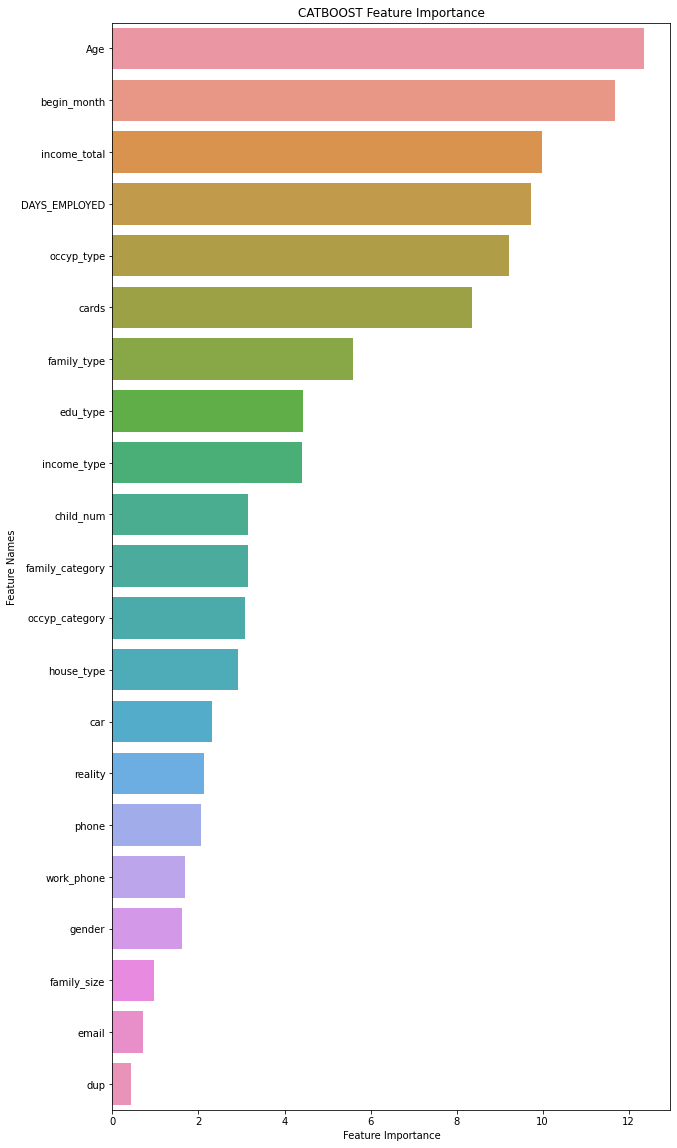

In [15]:
plot_feature_importance(model.get_feature_importance(),X_test.columns,'CATBOOST')

In [7]:
data_df = pd.read_csv('./pre_final.csv', index_col=0) # 엑셀 파일 읽기
credit_Y = data_df['credit']
credit_X = data_df.drop(['credit'],axis=1)

In [43]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(credit_X, credit_Y, test_size=test_size, random_state=random_state)
x_train_transformed , x_test_transformed, preprocessor = pipe_processing(X_train, X_test)
new_col_names = get_feature_names(preprocessor)
x_train_transformed = pd.DataFrame(x_train_transformed,columns=new_col_names)
x_test_transformed = pd.DataFrame(x_test_transformed,columns=new_col_names)
models = [XGBClassifier(objective='multi:softprob',num_classes=3,random_state=random_state,eval_metric='mlogloss'),
          LGBMClassifier(random_state=random_state),
          CatBoostClassifier(iterations = 2000, random_state=random_state,)]

S_train, S_test = stacking(models, 
                       x_train_transformed, y_train, x_test_transformed, 
                       regression = False, 
                       metric = accuracy_score, 
                       n_folds = 5, stratified = True, shuffle = True, 
                       random_state = 0, verbose = 0)


model = XGBClassifier(objective='multi:softprob',num_classes=3,random_state=random_state )
model = model.fit(S_train, y_train)  # <- x_train_transformed (not x_train)

y_pred_proba = model.predict_proba(S_test)
y_pred = model.predict(S_test) # 예측 라벨
print("logloss :",log_loss(y_test,y_pred_proba))
print("정확도 :",accuracy_score(y_pred, y_test))

[18:34:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:35:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:35:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This c

121:	learn: 0.7827448	total: 1.75s	remaining: 26.9s
122:	learn: 0.7824781	total: 1.76s	remaining: 26.8s
123:	learn: 0.7821874	total: 1.77s	remaining: 26.8s
124:	learn: 0.7820265	total: 1.78s	remaining: 26.8s
125:	learn: 0.7816853	total: 1.8s	remaining: 26.8s
126:	learn: 0.7814343	total: 1.81s	remaining: 26.7s
127:	learn: 0.7811484	total: 1.83s	remaining: 26.7s
128:	learn: 0.7810033	total: 1.83s	remaining: 26.6s
129:	learn: 0.7807537	total: 1.84s	remaining: 26.5s
130:	learn: 0.7804942	total: 1.85s	remaining: 26.5s
131:	learn: 0.7801608	total: 1.87s	remaining: 26.4s
132:	learn: 0.7800916	total: 1.88s	remaining: 26.3s
133:	learn: 0.7798472	total: 1.88s	remaining: 26.2s
134:	learn: 0.7797322	total: 1.89s	remaining: 26.1s
135:	learn: 0.7795739	total: 1.91s	remaining: 26.1s
136:	learn: 0.7793919	total: 1.92s	remaining: 26.1s
137:	learn: 0.7792392	total: 1.94s	remaining: 26.1s
138:	learn: 0.7790042	total: 1.96s	remaining: 26.2s
139:	learn: 0.7786772	total: 1.97s	remaining: 26.2s
140:	learn: 0

285:	learn: 0.7457215	total: 4.18s	remaining: 25s
286:	learn: 0.7453234	total: 4.19s	remaining: 25s
287:	learn: 0.7451006	total: 4.21s	remaining: 25s
288:	learn: 0.7449685	total: 4.22s	remaining: 25s
289:	learn: 0.7447774	total: 4.24s	remaining: 25s
290:	learn: 0.7446259	total: 4.25s	remaining: 25s
291:	learn: 0.7444374	total: 4.26s	remaining: 25s
292:	learn: 0.7442329	total: 4.28s	remaining: 24.9s
293:	learn: 0.7440208	total: 4.29s	remaining: 24.9s
294:	learn: 0.7438566	total: 4.31s	remaining: 24.9s
295:	learn: 0.7436474	total: 4.32s	remaining: 24.9s
296:	learn: 0.7435450	total: 4.33s	remaining: 24.9s
297:	learn: 0.7434386	total: 4.35s	remaining: 24.8s
298:	learn: 0.7430384	total: 4.37s	remaining: 24.9s
299:	learn: 0.7428429	total: 4.39s	remaining: 24.9s
300:	learn: 0.7426762	total: 4.41s	remaining: 24.9s
301:	learn: 0.7424301	total: 4.42s	remaining: 24.9s
302:	learn: 0.7422920	total: 4.43s	remaining: 24.8s
303:	learn: 0.7420802	total: 4.45s	remaining: 24.8s
304:	learn: 0.7417631	tota

451:	learn: 0.7132795	total: 6.8s	remaining: 23.3s
452:	learn: 0.7130486	total: 6.81s	remaining: 23.3s
453:	learn: 0.7129691	total: 6.83s	remaining: 23.3s
454:	learn: 0.7127894	total: 6.84s	remaining: 23.2s
455:	learn: 0.7126252	total: 6.86s	remaining: 23.2s
456:	learn: 0.7124784	total: 6.87s	remaining: 23.2s
457:	learn: 0.7121950	total: 6.88s	remaining: 23.2s
458:	learn: 0.7120585	total: 6.9s	remaining: 23.2s
459:	learn: 0.7118782	total: 6.91s	remaining: 23.1s
460:	learn: 0.7115409	total: 6.93s	remaining: 23.1s
461:	learn: 0.7111934	total: 6.94s	remaining: 23.1s
462:	learn: 0.7110736	total: 6.96s	remaining: 23.1s
463:	learn: 0.7107139	total: 6.98s	remaining: 23.1s
464:	learn: 0.7103833	total: 6.99s	remaining: 23.1s
465:	learn: 0.7102751	total: 7s	remaining: 23.1s
466:	learn: 0.7101426	total: 7.02s	remaining: 23.1s
467:	learn: 0.7099331	total: 7.04s	remaining: 23s
468:	learn: 0.7097398	total: 7.05s	remaining: 23s
469:	learn: 0.7095517	total: 7.07s	remaining: 23s
470:	learn: 0.7092111	t

614:	learn: 0.6869265	total: 9.17s	remaining: 20.7s
615:	learn: 0.6868293	total: 9.18s	remaining: 20.6s
616:	learn: 0.6865721	total: 9.2s	remaining: 20.6s
617:	learn: 0.6864003	total: 9.21s	remaining: 20.6s
618:	learn: 0.6862570	total: 9.23s	remaining: 20.6s
619:	learn: 0.6861031	total: 9.25s	remaining: 20.6s
620:	learn: 0.6859060	total: 9.26s	remaining: 20.6s
621:	learn: 0.6857355	total: 9.28s	remaining: 20.6s
622:	learn: 0.6856674	total: 9.29s	remaining: 20.5s
623:	learn: 0.6854497	total: 9.31s	remaining: 20.5s
624:	learn: 0.6853072	total: 9.33s	remaining: 20.5s
625:	learn: 0.6852020	total: 9.34s	remaining: 20.5s
626:	learn: 0.6848990	total: 9.36s	remaining: 20.5s
627:	learn: 0.6847108	total: 9.37s	remaining: 20.5s
628:	learn: 0.6845894	total: 9.38s	remaining: 20.4s
629:	learn: 0.6844839	total: 9.39s	remaining: 20.4s
630:	learn: 0.6842315	total: 9.41s	remaining: 20.4s
631:	learn: 0.6841448	total: 9.42s	remaining: 20.4s
632:	learn: 0.6839867	total: 9.43s	remaining: 20.4s
633:	learn: 0

784:	learn: 0.6619032	total: 11.8s	remaining: 18.3s
785:	learn: 0.6616508	total: 11.8s	remaining: 18.3s
786:	learn: 0.6615888	total: 11.9s	remaining: 18.3s
787:	learn: 0.6614967	total: 11.9s	remaining: 18.3s
788:	learn: 0.6614243	total: 11.9s	remaining: 18.3s
789:	learn: 0.6613377	total: 11.9s	remaining: 18.3s
790:	learn: 0.6612569	total: 12s	remaining: 18.3s
791:	learn: 0.6610725	total: 12s	remaining: 18.3s
792:	learn: 0.6608966	total: 12s	remaining: 18.3s
793:	learn: 0.6607136	total: 12.1s	remaining: 18.3s
794:	learn: 0.6605031	total: 12.1s	remaining: 18.3s
795:	learn: 0.6603873	total: 12.1s	remaining: 18.3s
796:	learn: 0.6602843	total: 12.1s	remaining: 18.3s
797:	learn: 0.6600377	total: 12.1s	remaining: 18.3s
798:	learn: 0.6599302	total: 12.2s	remaining: 18.3s
799:	learn: 0.6598259	total: 12.2s	remaining: 18.3s
800:	learn: 0.6597132	total: 12.2s	remaining: 18.3s
801:	learn: 0.6595745	total: 12.2s	remaining: 18.3s
802:	learn: 0.6594363	total: 12.2s	remaining: 18.2s
803:	learn: 0.6593

954:	learn: 0.6403975	total: 14.8s	remaining: 16.2s
955:	learn: 0.6403270	total: 14.8s	remaining: 16.2s
956:	learn: 0.6401502	total: 14.8s	remaining: 16.1s
957:	learn: 0.6400571	total: 14.8s	remaining: 16.1s
958:	learn: 0.6399042	total: 14.8s	remaining: 16.1s
959:	learn: 0.6397617	total: 14.9s	remaining: 16.1s
960:	learn: 0.6396441	total: 14.9s	remaining: 16.1s
961:	learn: 0.6395219	total: 14.9s	remaining: 16.1s
962:	learn: 0.6393550	total: 14.9s	remaining: 16s
963:	learn: 0.6392061	total: 14.9s	remaining: 16s
964:	learn: 0.6391544	total: 14.9s	remaining: 16s
965:	learn: 0.6390442	total: 14.9s	remaining: 16s
966:	learn: 0.6388217	total: 14.9s	remaining: 16s
967:	learn: 0.6386924	total: 15s	remaining: 15.9s
968:	learn: 0.6386356	total: 15s	remaining: 15.9s
969:	learn: 0.6384259	total: 15s	remaining: 15.9s
970:	learn: 0.6383183	total: 15s	remaining: 15.9s
971:	learn: 0.6382165	total: 15s	remaining: 15.9s
972:	learn: 0.6381424	total: 15s	remaining: 15.9s
973:	learn: 0.6378677	total: 15s	r

1124:	learn: 0.6211265	total: 17.2s	remaining: 13.4s
1125:	learn: 0.6210420	total: 17.2s	remaining: 13.3s
1126:	learn: 0.6209764	total: 17.2s	remaining: 13.3s
1127:	learn: 0.6208798	total: 17.2s	remaining: 13.3s
1128:	learn: 0.6207750	total: 17.2s	remaining: 13.3s
1129:	learn: 0.6206837	total: 17.2s	remaining: 13.3s
1130:	learn: 0.6205245	total: 17.3s	remaining: 13.3s
1131:	learn: 0.6204028	total: 17.3s	remaining: 13.2s
1132:	learn: 0.6203339	total: 17.3s	remaining: 13.2s
1133:	learn: 0.6202331	total: 17.3s	remaining: 13.2s
1134:	learn: 0.6201068	total: 17.3s	remaining: 13.2s
1135:	learn: 0.6199834	total: 17.3s	remaining: 13.2s
1136:	learn: 0.6198850	total: 17.3s	remaining: 13.1s
1137:	learn: 0.6197907	total: 17.3s	remaining: 13.1s
1138:	learn: 0.6196752	total: 17.3s	remaining: 13.1s
1139:	learn: 0.6194913	total: 17.4s	remaining: 13.1s
1140:	learn: 0.6193414	total: 17.4s	remaining: 13.1s
1141:	learn: 0.6192766	total: 17.4s	remaining: 13.1s
1142:	learn: 0.6192134	total: 17.4s	remaining:

1284:	learn: 0.6041762	total: 19.6s	remaining: 10.9s
1285:	learn: 0.6040725	total: 19.6s	remaining: 10.9s
1286:	learn: 0.6039977	total: 19.6s	remaining: 10.9s
1287:	learn: 0.6039295	total: 19.6s	remaining: 10.8s
1288:	learn: 0.6038635	total: 19.6s	remaining: 10.8s
1289:	learn: 0.6038202	total: 19.6s	remaining: 10.8s
1290:	learn: 0.6037262	total: 19.6s	remaining: 10.8s
1291:	learn: 0.6035989	total: 19.7s	remaining: 10.8s
1292:	learn: 0.6034574	total: 19.7s	remaining: 10.8s
1293:	learn: 0.6033836	total: 19.7s	remaining: 10.7s
1294:	learn: 0.6033195	total: 19.7s	remaining: 10.7s
1295:	learn: 0.6032354	total: 19.7s	remaining: 10.7s
1296:	learn: 0.6030054	total: 19.7s	remaining: 10.7s
1297:	learn: 0.6028841	total: 19.7s	remaining: 10.7s
1298:	learn: 0.6028052	total: 19.8s	remaining: 10.7s
1299:	learn: 0.6027202	total: 19.8s	remaining: 10.6s
1300:	learn: 0.6025971	total: 19.8s	remaining: 10.6s
1301:	learn: 0.6024363	total: 19.8s	remaining: 10.6s
1302:	learn: 0.6023282	total: 19.8s	remaining:

1444:	learn: 0.5888547	total: 22.1s	remaining: 8.5s
1445:	learn: 0.5887658	total: 22.1s	remaining: 8.48s
1446:	learn: 0.5887144	total: 22.2s	remaining: 8.47s
1447:	learn: 0.5886145	total: 22.2s	remaining: 8.45s
1448:	learn: 0.5885416	total: 22.2s	remaining: 8.44s
1449:	learn: 0.5883955	total: 22.2s	remaining: 8.42s
1450:	learn: 0.5882996	total: 22.2s	remaining: 8.41s
1451:	learn: 0.5881883	total: 22.3s	remaining: 8.4s
1452:	learn: 0.5880879	total: 22.3s	remaining: 8.39s
1453:	learn: 0.5879826	total: 22.3s	remaining: 8.38s
1454:	learn: 0.5878378	total: 22.4s	remaining: 8.38s
1455:	learn: 0.5877031	total: 22.4s	remaining: 8.37s
1456:	learn: 0.5875838	total: 22.4s	remaining: 8.36s
1457:	learn: 0.5874468	total: 22.4s	remaining: 8.34s
1458:	learn: 0.5873443	total: 22.5s	remaining: 8.33s
1459:	learn: 0.5872621	total: 22.5s	remaining: 8.32s
1460:	learn: 0.5872127	total: 22.5s	remaining: 8.31s
1461:	learn: 0.5870041	total: 22.6s	remaining: 8.32s
1462:	learn: 0.5869087	total: 22.6s	remaining: 8

1603:	learn: 0.5744225	total: 25.3s	remaining: 6.24s
1604:	learn: 0.5743460	total: 25.3s	remaining: 6.22s
1605:	learn: 0.5742425	total: 25.3s	remaining: 6.21s
1606:	learn: 0.5741839	total: 25.3s	remaining: 6.19s
1607:	learn: 0.5741529	total: 25.3s	remaining: 6.17s
1608:	learn: 0.5740870	total: 25.3s	remaining: 6.16s
1609:	learn: 0.5740323	total: 25.4s	remaining: 6.14s
1610:	learn: 0.5739442	total: 25.4s	remaining: 6.13s
1611:	learn: 0.5739099	total: 25.4s	remaining: 6.11s
1612:	learn: 0.5738494	total: 25.4s	remaining: 6.09s
1613:	learn: 0.5737872	total: 25.4s	remaining: 6.08s
1614:	learn: 0.5735979	total: 25.4s	remaining: 6.06s
1615:	learn: 0.5735460	total: 25.5s	remaining: 6.05s
1616:	learn: 0.5733873	total: 25.5s	remaining: 6.03s
1617:	learn: 0.5732948	total: 25.5s	remaining: 6.02s
1618:	learn: 0.5732116	total: 25.5s	remaining: 6s
1619:	learn: 0.5731242	total: 25.5s	remaining: 5.99s
1620:	learn: 0.5730647	total: 25.5s	remaining: 5.97s
1621:	learn: 0.5729861	total: 25.6s	remaining: 5.

1759:	learn: 0.5616809	total: 27.6s	remaining: 3.77s
1760:	learn: 0.5615581	total: 27.6s	remaining: 3.75s
1761:	learn: 0.5615126	total: 27.7s	remaining: 3.73s
1762:	learn: 0.5613953	total: 27.7s	remaining: 3.72s
1763:	learn: 0.5613167	total: 27.7s	remaining: 3.7s
1764:	learn: 0.5612850	total: 27.7s	remaining: 3.69s
1765:	learn: 0.5612227	total: 27.7s	remaining: 3.67s
1766:	learn: 0.5611135	total: 27.7s	remaining: 3.66s
1767:	learn: 0.5610383	total: 27.8s	remaining: 3.64s
1768:	learn: 0.5609602	total: 27.8s	remaining: 3.63s
1769:	learn: 0.5608745	total: 27.8s	remaining: 3.61s
1770:	learn: 0.5608136	total: 27.8s	remaining: 3.6s
1771:	learn: 0.5607407	total: 27.8s	remaining: 3.58s
1772:	learn: 0.5606912	total: 27.8s	remaining: 3.56s
1773:	learn: 0.5604940	total: 27.9s	remaining: 3.55s
1774:	learn: 0.5604393	total: 27.9s	remaining: 3.53s
1775:	learn: 0.5603554	total: 27.9s	remaining: 3.52s
1776:	learn: 0.5602559	total: 27.9s	remaining: 3.5s
1777:	learn: 0.5601379	total: 27.9s	remaining: 3.

1928:	learn: 0.5479212	total: 30s	remaining: 1.1s
1929:	learn: 0.5478561	total: 30s	remaining: 1.09s
1930:	learn: 0.5477605	total: 30s	remaining: 1.07s
1931:	learn: 0.5476862	total: 30s	remaining: 1.06s
1932:	learn: 0.5476180	total: 30s	remaining: 1.04s
1933:	learn: 0.5475325	total: 30.1s	remaining: 1.02s
1934:	learn: 0.5474844	total: 30.1s	remaining: 1.01s
1935:	learn: 0.5474346	total: 30.1s	remaining: 995ms
1936:	learn: 0.5474120	total: 30.1s	remaining: 979ms
1937:	learn: 0.5472997	total: 30.1s	remaining: 963ms
1938:	learn: 0.5472445	total: 30.1s	remaining: 948ms
1939:	learn: 0.5471207	total: 30.1s	remaining: 932ms
1940:	learn: 0.5470475	total: 30.2s	remaining: 917ms
1941:	learn: 0.5469778	total: 30.2s	remaining: 901ms
1942:	learn: 0.5469121	total: 30.2s	remaining: 885ms
1943:	learn: 0.5467115	total: 30.2s	remaining: 870ms
1944:	learn: 0.5466564	total: 30.2s	remaining: 854ms
1945:	learn: 0.5466185	total: 30.2s	remaining: 839ms
1946:	learn: 0.5465150	total: 30.2s	remaining: 823ms
1947

ValueError: shape mismatch: value array of shape (4232,1) could not be broadcast to indexing result of shape (4232,)